# Data Analysis

Data analysis notebook for the results of the `DINCAE.jl` model training

In [4]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [5]:
i = 4 # Index of the trial to analyze
base_folder = f"./results/trial_{i}/"

result = xarray.open_dataset(f"{base_folder}/data-avg.nc") # Model output
# subset = xarray.open_dataset(f"{base_folder}/modis_subset.nc") # Raw data
cleanup = xarray.open_dataset(f"{base_folder}/modis_cleanup.nc") # Cleaned data (pixels with quality flags > 3 or temperature > 40 removed)
cleanup_clouds = xarray.open_dataset(f"{base_folder}/modis_cleanup_add_clouds.nc") # Cleaned data with simulated clouds added

In [18]:
cleanup_clouds

<xarray.Dataset> Size: 2GB
Dimensions:          (time: 9006, lat: 168, lon: 144, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time             (time) datetime64[ns] 72kB 2000-12-31 ... 2023-12-31
  * lat              (lat) float32 672B 46.23 46.19 46.15 ... 39.35 39.31 39.27
  * lon              (lon) float32 576B 11.69 11.73 11.77 ... 17.56 17.6 17.65
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    qual_sst         (time, lat, lon) float32 871MB ...
    palette          (time, rgb, eightbitcolor) uint8 7MB ...
    sst              (time, lat, lon) float32 871MB nan nan nan ... 0.0 0.0 0.0
    mask             (lat, lon) int8 24kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    count_nomissing  (lat, lon) int32 97kB ...

In [6]:
# Extracting the relevant data arrays

result_sst = result["sst"].values
# subset_sst = subset["sst"].values
cleanup_sst = cleanup["sst"].values
cleanup_clouds_sst = cleanup_clouds["sst"].values
sea_mask = cleanup_clouds["mask"].values.astype(bool) # 1 = water, 0 = land

N = result_sst.shape[0]

result_sst.shape, cleanup_sst.shape, cleanup_clouds_sst.shape, sea_mask.dtype, sea_mask.shape

((9006, 168, 144),
 (9006, 168, 144),
 (9006, 168, 144),
 dtype('bool'),
 (168, 144))

In [7]:
# Calculate in which days the clouds were applied

added_clouds = []

for i in range(N):
    missing_values = sum(np.isnan(cleanup_sst[i].flatten()))
    missing_values_clouds = sum(np.isnan(cleanup_clouds_sst[i].flatten()))
    if missing_values_clouds > missing_values:
        added_clouds.append(i)
        
print("Added clouds in days:\n", added_clouds)

Added clouds in days:
 [2, 4, 32, 49, 54, 69, 71, 85, 96, 110, 112, 115, 133, 181, 205, 206, 212, 218, 231, 232, 237, 250, 252, 264, 267, 282, 332, 383, 444, 450, 488, 513, 518, 578, 628, 634, 685, 699, 710, 750, 781, 858, 860, 879, 972, 998, 1024, 1036, 1077, 1112, 1134, 1156, 1198, 1211, 1251, 1252, 1281, 1304, 1305, 1323, 1330, 1337, 1342, 1352, 1359, 1385, 1396, 1464, 1535, 1551, 1578, 1630, 1643, 1659, 1689, 1737, 1768, 1773, 1826, 1838, 1856, 1888, 1944, 1948, 1964, 1965, 2016, 2017, 2028, 2090, 2173, 2183, 2228, 2256, 2271, 2307, 2310, 2333, 2337, 2346, 2370, 2388, 2399, 2404, 2436, 2459, 2460, 2483, 2495, 2508, 2531, 2571, 2620, 2622, 2681, 2703, 2762, 2785, 2789, 2824, 2841, 2864, 2910, 2918, 2921, 2952, 2974, 2991, 3004, 3007, 3014, 3017, 3075, 3085, 3145, 3202, 3222, 3228, 3233, 3249, 3275, 3281, 3330, 3345, 3369, 3373, 3379, 3391, 3407, 3427, 3431, 3448, 3466, 3512, 3523, 3552, 3560, 3573, 3608, 3639, 3663, 3701, 3724, 3770, 3826, 3829, 3898, 3912, 3927, 3950, 3964, 4016, 4

In [36]:
len(added_clouds)

523

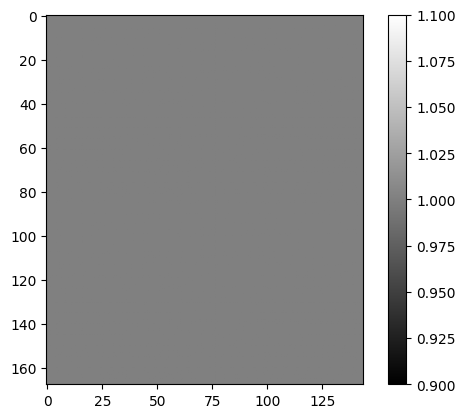

In [8]:
plt.imshow(sea_mask, cmap='gray')
plt.colorbar()

RMSE:
 Model: 6.587176322937012
 Mean: 2.5562219619750977
Min: -20.33245277404785, Max: 19.387157440185547


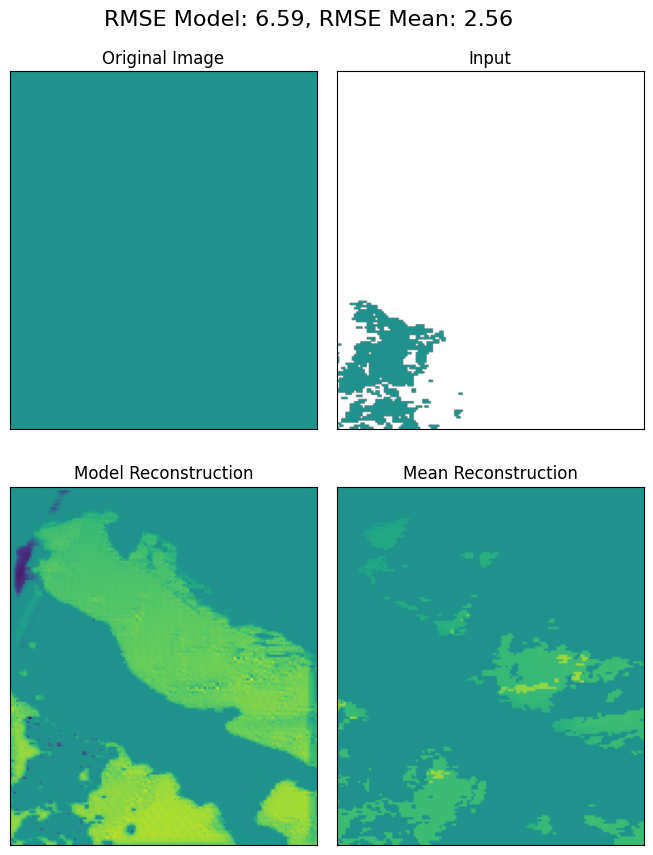

In [38]:
time_window = 3 # Specify the time window for reconstruction
n_days = time_window // 2 # Get the number of days before and after the current day

# for i in added_clouds[0:100]:
    
i = 710
reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
# The applied clouds are where cleanup_clouds_sst is NaN but and the original image isn't
cloud_mask = np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i])

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = np.where(cloud_mask, result_sst[i], cleanup_sst[i])

# Calculate the mean of the surrounding days
mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)
# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = np.where(cloud_mask, mean_res, cleanup_sst[i])

# Calculate RMSE between the reconstructed and original images
RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_mean}")

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst[i]), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst[i]), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(2, 2, figsize=(7, 9), sharex=True, sharey=True)
fig.suptitle(f"RMSE Model: {RMSE_model:.2f}, RMSE Mean: {RMSE_mean:.2f}", fontsize=16)

axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Input')

axs[1, 0].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Model Reconstruction')

axs[1, 1].imshow(reconstructed_mean_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Mean Reconstruction')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.savefig(f"{base_folder}/figs/{i}.png", dpi=300)
    # plt.close()

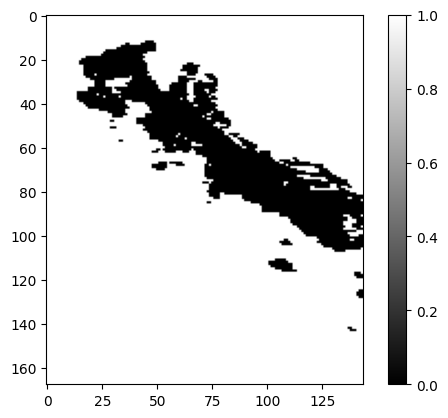

In [10]:
plt.imshow(np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i]), cmap='gray')
plt.colorbar()

## Calculate mean RMSE

Calculate the mean RMSE of the dataset, using:
- The output of the model
- The mean of the previous and following days

In [26]:
# Calculate where the clouds were applied, only considering water areas
mask = np.isnan(cleanup_clouds_sst) & ~np.isnan(cleanup_sst)

In [27]:
RMSE_rec = []
RMSE_mean = []

for i in range(n_days, N - n_days):
   
    if not mask[i].any(): # If no clouds were applied, skip this iteration
        continue

    diff = (result_sst[i] - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue
    rec = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for reconstruction

    reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
    mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days
    diff = (mean_res - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue

    mn = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for mean reconstruction

    if np.isnan(rec) or np.isnan(mn):
        print(f"Skipping {i} due to NaN values in RMSE calculations.")
        continue
        
    RMSE_rec.append(rec)
    RMSE_mean.append(mn)

print("Number of valid RMSE values:", len(RMSE_rec))
print("Mean RMSE Reconstruction:", np.mean(RMSE_rec))
print("Mean RMSE Mean:", np.mean(RMSE_mean))


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_61909/4164045493.py:15: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days


Number of valid RMSE values: 522
Mean RMSE Reconstruction: 7.7486815
Mean RMSE Mean: 4.982247


## Plot the loss

In [28]:
with open(base_folder + 'loss.txt', 'r') as f:
    loss = f.read()
    
loss = loss.split('\n')

loss = [float(x) for x in loss if x]  # Convert to float and remove empty strings

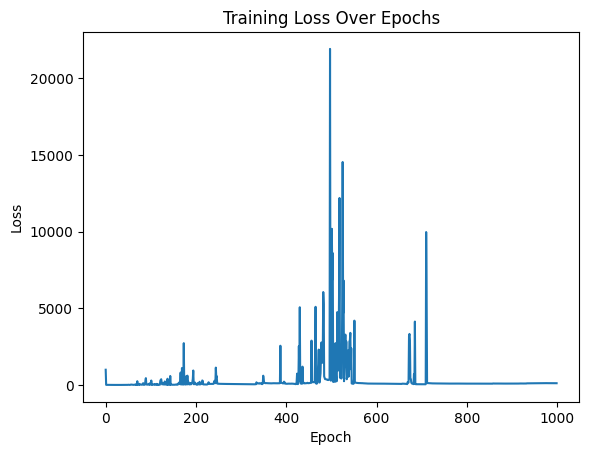

In [29]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()